## Importation librarires 

In [1]:
import zipfile
import cv2
import numpy as np
import os 
from random import shuffle
from tqdm import tqdm
import glob
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Activation, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
import seaborn as sns
from scipy import ndimage



In [2]:
try:
    import scipy
    print(scipy.__version__)
    print(ndimage.affine_transform.__doc__)
    from scipy import ndimage 
except ImportError as e:
    print ('test .....', e)
    scipy = None




1.7.3

    Apply an affine transformation.

    Given an output image pixel index vector ``o``, the pixel value
    is determined from the input image at position
    ``np.dot(matrix, o) + offset``.

    This does 'pull' (or 'backward') resampling, transforming the output space
    to the input to locate data. Affine transformations are often described in
    the 'push' (or 'forward') direction, transforming input to output. If you
    have a matrix for the 'push' transformation, use its inverse
    (:func:`numpy.linalg.inv`) in this function.

    Parameters
    ----------
    input : array_like
        The input array.
    matrix : ndarray
        The inverse coordinate transformation matrix, mapping output
        coordinates to input coordinates. If ``ndim`` is the number of
        dimensions of ``input``, the given matrix must have one of the
        following shapes:

            - ``(ndim, ndim)``: the linear transformation matrix for each
              output coordinate.
     

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


## Data importattion 

In [4]:

## Data extraction from zip file train and test data 
train_zip='../input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref=zipfile.ZipFile(train_zip,'r').extractall('./')

test_zip = '../input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref=zipfile.ZipFile(test_zip,'r').extractall('./')

In [5]:
## Definit the data path for train and test 

TRAIN_DIR = r'./train/'

print(TRAIN_DIR)
TEST_DIR = r'./test/'

print(TRAIN_DIR)
IMG_SIZE = 100
LR = 1e-3 

## save the model name 
MODEL_NAME = 'dogvscats--{}--{}.model'.format(LR,'conv-basic')

val_loss = {}
accuracy = {}


./train/
./train/


In [6]:
## Display the images contain in the TRAIN_DIR 
os.listdir(TRAIN_DIR)

['dog.106.jpg',
 'cat.6013.jpg',
 'dog.2782.jpg',
 'dog.1294.jpg',
 'dog.11781.jpg',
 'cat.283.jpg',
 'dog.4402.jpg',
 'cat.2768.jpg',
 'cat.9552.jpg',
 'dog.8796.jpg',
 'dog.7622.jpg',
 'dog.12082.jpg',
 'cat.9524.jpg',
 'cat.2160.jpg',
 'cat.2545.jpg',
 'dog.1925.jpg',
 'dog.2484.jpg',
 'dog.2109.jpg',
 'dog.9500.jpg',
 'cat.7382.jpg',
 'cat.2909.jpg',
 'dog.10378.jpg',
 'cat.9038.jpg',
 'cat.7934.jpg',
 'dog.2429.jpg',
 'dog.1503.jpg',
 'dog.2962.jpg',
 'dog.3390.jpg',
 'dog.9733.jpg',
 'dog.7417.jpg',
 'cat.575.jpg',
 'cat.10625.jpg',
 'cat.3862.jpg',
 'dog.1309.jpg',
 'cat.12064.jpg',
 'dog.9291.jpg',
 'cat.1257.jpg',
 'cat.8084.jpg',
 'dog.3406.jpg',
 'cat.6335.jpg',
 'cat.8537.jpg',
 'dog.6123.jpg',
 'dog.5839.jpg',
 'dog.9499.jpg',
 'cat.8617.jpg',
 'dog.5691.jpg',
 'dog.3963.jpg',
 'cat.1712.jpg',
 'dog.2615.jpg',
 'dog.11988.jpg',
 'dog.4905.jpg',
 'cat.9192.jpg',
 'dog.12306.jpg',
 'cat.1588.jpg',
 'cat.5232.jpg',
 'dog.1975.jpg',
 'cat.9592.jpg',
 'dog.11426.jpg',
 'dog.419

In [7]:
## Split class and image in TRAIN data and create a list contain image and class (target)
class_name = [i.split('.')[0] for i in os.listdir(TRAIN_DIR)]
image_name =  [i for i in os.listdir(TRAIN_DIR)]

In [8]:
## Create a dataframe for two column class_name and image_name
df = pd.DataFrame({'class_name':class_name,'image_name':image_name} )

In [9]:
df.head()

,class_name,image_name
0,dog,dog.106.jpg
1,cat,cat.6013.jpg
2,dog,dog.2782.jpg
3,dog,dog.1294.jpg
4,dog,dog.11781.jpg


In this dataframe, class_name is the target take only two distinck value( cat and dog) then it classification problem 

In [10]:
df.drop(df.index[-1], inplace=True)

In [11]:
df

,class_name,image_name
0,dog,dog.106.jpg
1,cat,cat.6013.jpg
2,dog,dog.2782.jpg
3,dog,dog.1294.jpg
4,dog,dog.11781.jpg
...,...,...
24994,dog,dog.11559.jpg
24995,dog,dog.659.jpg
24996,cat,cat.12440.jpg
24997,dog,dog.7117.jpg


In [12]:
## Data augmentation 
## ImageDataGenerator function from Keras_preprocessing 
train_datagen = ImageDataGenerator(
                rotation_range=15, 
                rescale=1./255,
                shear_range=0.1, 
                zoom_range=0.2,
                horizontal_flip=True, 
                width_shift_range=0.1,
                height_shift_range=0.1,
                validation_split=0.2)

In [13]:
## Split train_fatagen into 2 train_generator and val_generator 

# since the datagen is splitted in training and validation,
# make sure to set subsets correctly

train_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.2)


train_generator = train_datagen.flow_from_dataframe(
                    df,
                    TRAIN_DIR, 
                    x_col = 'image_name',
                    y_col = 'class_name',
                    target_size =(224,224),
                    class_mode = 'binary',
                    batch_size=32,
                    shuffle=False,
                    subset= 'training')
# make sure shuffle is set to false, so the predictions are done on the same order
# as they appear on the directory. batch_size should be 1 to make the
# predictions image by image 
val_generator = train_datagen.flow_from_dataframe(
                    df,
                    TRAIN_DIR, 
                    x_col = 'image_name',
                    y_col = 'class_name',
                    target_size =(224,224),
                    class_mode = 'binary',
                    batch_size=32,
                    shuffle=False,
                    subset= 'validation')

Found 20000 validated image filenames belonging to 2 classes.
Found 4999 validated image filenames belonging to 2 classes.


In [14]:
# simple Convolutional layer, Dropout and GlobalMaxPooling for the sake of simplicity. You can plug your model right here and test it! Just make sure input_shape from Conv2D is the same that target_size in the generators.
## Convolution layer  
input = Input(shape=(224,224, 3))

x = Conv2D(filters=256,kernel_size=3,padding='same' )(input)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPool2D(pool_size=2)(x)


x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)


2022-11-01 17:22:38.172770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:22:38.173735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:22:38.561169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:22:38.562044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 17:22:38.562852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [15]:
## Build the model
model = Model(input, output)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 256)     7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 256)     1024      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512   

In [17]:
## Binary classification( cat and dog )
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')

In [18]:
model.fit(train_generator  , validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

2022-11-01 17:22:44.713322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-01 17:22:47.751120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 76s 462ms/step - loss: 1.4190 - accuracy: 0.5635 - val_loss: 0.8464 - val_accuracy: 0.5767
Epoch 2/50
128/128 [==============================] - 59s 461ms/step - loss: 1.2793 - accuracy: 0.5923 - val_loss: 0.8920 - val_accuracy: 0.5847
Epoch 3/50
128/128 [==============================] - 59s 460ms/step - loss: 1.2447 - accuracy: 0.6257 - val_loss: 0.9320 - val_accuracy: 0.6087
Epoch 4/50
128/128 [==============================] - 59s 458ms/step - loss: 1.2154 - accuracy: 0.6277 - val_loss: 1.3063 - val_accuracy: 0.6021
Epoch 5/50
128/128 [==============================] - 58s 456ms/step - loss: 1.0839 - accuracy: 0.6372 - val_loss: 1.3046 - val_accuracy: 0.5991
Epoch 6/50
128/128 [==============================] - 59s 462ms/step - loss: 1.1405 - accuracy: 0.6250 - val_loss: 2.2470 - val_accuracy: 0.5379
Epoch 7/50
128/128 [==============================] - 59s 465ms/step - loss: 1.0735 - accuracy: 0.6355 - val_loss: 1.4828 - val_accuracy: 0.5

In [19]:
model.history.history

{'loss': [1.418962836265564,
  1.2792588472366333,
  1.2447012662887573,
  1.2153514623641968,
  1.0839074850082397,
  1.1405158042907715,
  1.0734988451004028,
  0.9469156861305237,
  0.8783397674560547,
  0.8847160339355469,
  0.7820910215377808,
  0.8792282938957214,
  0.7291527986526489,
  0.6977424621582031,
  0.6872163414955139,
  0.6355064511299133,
  0.6652443408966064,
  0.6089405417442322,
  0.6051957607269287,
  0.5841478109359741,
  0.5815958976745605,
  0.586150050163269,
  0.5276837944984436,
  0.5164841413497925,
  0.5572398900985718,
  0.5076062679290771,
  0.5143029093742371,
  0.49716848134994507,
  0.4890374541282654,
  0.4652310013771057,
  0.45816728472709656,
  0.46667781472206116,
  0.44226932525634766,
  0.4288325011730194,
  0.424530029296875,
  0.4401898980140686,
  0.4272859990596771,
  0.4050896465778351,
  0.39355966448783875,
  0.39923569560050964,
  0.3710779845714569,
  0.38887810707092285,
  0.4161032736301422,
  0.3797047734260559,
  0.3616562783718109

In [20]:
val_loss['conv_256_128_64'] = model.history.history['val_loss']
accuracy['conv_256_128_64'] = model.history.history['accuracy']

<AxesSubplot:>

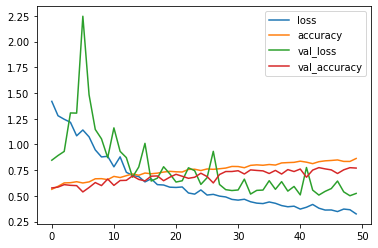

In [21]:
pd.DataFrame(model.history.history).plot()

In [22]:
input = Input(shape=(224,224, 3))

x = Conv2D(filters=256,kernel_size=3,padding='same' )(input)
x = Conv2D(filters=256,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model


model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='sgd')

model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50
128/128 [==============================] - 59s 459ms/step - loss: 0.2813 - accuracy: 0.8806 - val_loss: 0.4771 - val_accuracy: 0.7864
Epoch 2/50
128/128 [==============================] - 58s 457ms/step - loss: 0.2629 - accuracy: 0.8955 - val_loss: 0.4508 - val_accuracy: 0.8024
Epoch 3/50
128/128 [==============================] - 59s 459ms/step - loss: 0.2740 - accuracy: 0.8848 - val_loss: 0.4571 - val_accuracy: 0.7966
Epoch 4/50
128/128 [==============================] - 58s 455ms/step - loss: 0.2585 - accuracy: 0.8960 - val_loss: 0.4489 - val_accuracy: 0.8004
Epoch 5/50
128/128 [==============================] - 58s 457ms/step - loss: 0.2672 - accuracy: 0.8889 - val_loss: 0.4587 - val_accuracy: 0.8016
Epoch 6/50
128/128 [==============================] - 58s 457ms/step - loss: 0.2570 - accuracy: 0.8911 - val_loss: 0.4576 - val_accuracy: 0.8016
Epoch 7/50
128/128 [==============================] - 59s 461ms/step - loss: 0.2514 - accuracy: 0.8984 - val_loss: 0.4805 - val_ac

In [23]:
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='sgd')

In [24]:
model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50
128/128 [==============================] - 59s 458ms/step - loss: 0.1616 - accuracy: 0.9399 - val_loss: 0.5319 - val_accuracy: 0.8036
Epoch 2/50
128/128 [==============================] - 59s 458ms/step - loss: 0.1595 - accuracy: 0.9390 - val_loss: 0.5382 - val_accuracy: 0.7990
Epoch 3/50
128/128 [==============================] - 58s 457ms/step - loss: 0.1586 - accuracy: 0.9438 - val_loss: 0.5500 - val_accuracy: 0.7912
Epoch 4/50
128/128 [==============================] - 58s 456ms/step - loss: 0.1587 - accuracy: 0.9436 - val_loss: 0.5473 - val_accuracy: 0.7928
Epoch 5/50
128/128 [==============================] - 58s 457ms/step - loss: 0.1639 - accuracy: 0.9399 - val_loss: 0.5606 - val_accuracy: 0.7934
Epoch 6/50
128/128 [==============================] - 58s 452ms/step - loss: 0.1524 - accuracy: 0.9456 - val_loss: 0.5765 - val_accuracy: 0.7916
Epoch 7/50
128/128 [==============================] - 59s 463ms/step - loss: 0.1536 - accuracy: 0.9431 - val_loss: 0.5493 - val_ac

In [25]:
val_loss['conv_256x2_128x2_64'] = model.history.history['val_loss']
accuracy['conv_256x2_128x2_64'] = model.history.history['accuracy']

<AxesSubplot:>

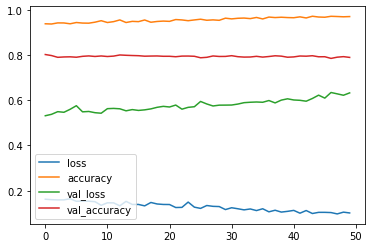

In [26]:
pd.DataFrame(model.history.history).plot()

In [27]:
input = Input(shape=(224,224, 3))

x = Conv2D(filters=128,kernel_size=3, strides=2 )(input)
x = Conv2D(filters=128,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3, strides=2 )(x)
x = Conv2D(filters=64,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.8)(x)



x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model = Model(input, output)

In [28]:
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')
model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50
128/128 [==============================] - 33s 250ms/step - loss: 1.3043 - accuracy: 0.5215 - val_loss: 0.6699 - val_accuracy: 0.5913
Epoch 2/50
128/128 [==============================] - 32s 251ms/step - loss: 1.0140 - accuracy: 0.5413 - val_loss: 0.6507 - val_accuracy: 0.6147
Epoch 3/50
128/128 [==============================] - 32s 252ms/step - loss: 0.8695 - accuracy: 0.5649 - val_loss: 0.6576 - val_accuracy: 0.6085
Epoch 4/50
128/128 [==============================] - 32s 253ms/step - loss: 0.7453 - accuracy: 0.6003 - val_loss: 0.6278 - val_accuracy: 0.6483
Epoch 5/50
128/128 [==============================] - 33s 259ms/step - loss: 0.6809 - accuracy: 0.6243 - val_loss: 0.6240 - val_accuracy: 0.6421
Epoch 6/50
128/128 [==============================] - 33s 261ms/step - loss: 0.6533 - accuracy: 0.6362 - val_loss: 0.6289 - val_accuracy: 0.6433
Epoch 7/50
128/128 [==============================] - 32s 253ms/step - loss: 0.6391 - accuracy: 0.6428 - val_loss: 0.5987 - val_ac

In [29]:
val_loss['conv_128x2_64x2'] = model.history.history['val_loss']
accuracy['conv_128x2_64x2'] = model.history.history['accuracy']

<AxesSubplot:>

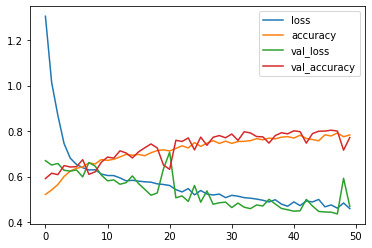

In [30]:
pd.DataFrame(model.history.history).plot()

In [31]:
input = Input(shape=(224,224, 3))


x = Conv2D(filters=64,kernel_size=3, strides=2 )(input)
x = Conv2D(filters=64,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.8)(x)

x = Conv2D(filters=32,kernel_size=3, strides=2 )(x)
x = Conv2D(filters=32,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.8)(x)



x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model = Model(input, output)


model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')
model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50
128/128 [==============================] - 32s 243ms/step - loss: 1.3681 - accuracy: 0.5137 - val_loss: 0.6883 - val_accuracy: 0.5647
Epoch 2/50
128/128 [==============================] - 32s 248ms/step - loss: 1.0124 - accuracy: 0.5330 - val_loss: 0.6700 - val_accuracy: 0.5851
Epoch 3/50
128/128 [==============================] - 31s 245ms/step - loss: 0.8775 - accuracy: 0.5256 - val_loss: 0.6691 - val_accuracy: 0.5917
Epoch 4/50
128/128 [==============================] - 31s 245ms/step - loss: 0.7752 - accuracy: 0.5415 - val_loss: 0.6733 - val_accuracy: 0.5665
Epoch 5/50
128/128 [==============================] - 31s 245ms/step - loss: 0.7214 - accuracy: 0.5554 - val_loss: 0.6540 - val_accuracy: 0.6191
Epoch 6/50
128/128 [==============================] - 32s 249ms/step - loss: 0.6918 - accuracy: 0.5659 - val_loss: 0.6596 - val_accuracy: 0.6055
Epoch 7/50
128/128 [==============================] - 32s 247ms/step - loss: 0.6774 - accuracy: 0.5835 - val_loss: 0.6485 - val_ac

In [32]:
val_loss['conv_128x2_64x2_32x2'] = model.history.history['val_loss']
accuracy['conv_128x2_64x2_32x2'] = model.history.history['accuracy']

<AxesSubplot:>

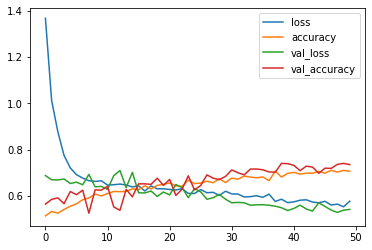

In [33]:
pd.DataFrame(model.history.history).plot()

<AxesSubplot:>

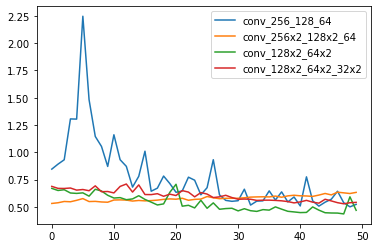

In [34]:

pd.DataFrame(val_loss).plot()

## Models comparaison by accuracy 

<AxesSubplot:>

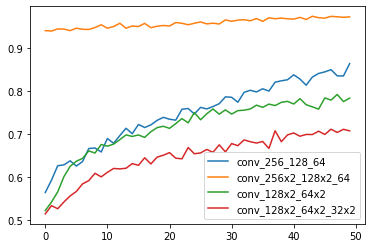

In [35]:

pd.DataFrame(accuracy).plot()

 
This graph compares the accuracy of different models, we see among these models, the model conv_256x2_128x2_64  appears more efficient in terms of accuracy. 



In [36]:
input = Input(shape=(224,224, 3))

x = Conv2D(filters=256,kernel_size=3,padding='same' )(input)
x = Conv2D(filters=256,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model




In [37]:
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='sgd')

model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50
128/128 [==============================] - 31s 242ms/step - loss: 0.5502 - accuracy: 0.7200 - val_loss: 0.5057 - val_accuracy: 0.7588
Epoch 2/50
128/128 [==============================] - 31s 240ms/step - loss: 0.5466 - accuracy: 0.7312 - val_loss: 0.5059 - val_accuracy: 0.7608
Epoch 3/50
128/128 [==============================] - 32s 249ms/step - loss: 0.5579 - accuracy: 0.7180 - val_loss: 0.5038 - val_accuracy: 0.7638
Epoch 4/50
128/128 [==============================] - 32s 248ms/step - loss: 0.5585 - accuracy: 0.7166 - val_loss: 0.5015 - val_accuracy: 0.7690
Epoch 5/50
128/128 [==============================] - 31s 245ms/step - loss: 0.5544 - accuracy: 0.7166 - val_loss: 0.5020 - val_accuracy: 0.7614
Epoch 6/50
128/128 [==============================] - 32s 252ms/step - loss: 0.5590 - accuracy: 0.7200 - val_loss: 0.5016 - val_accuracy: 0.7674
Epoch 7/50
128/128 [==============================] - 32s 250ms/step - loss: 0.5586 - accuracy: 0.7249 - val_loss: 0.5069 - val_ac

In [38]:
y_pred = model.predict(val_generator)

In [39]:
y_pred  = y_pred>0.5

In [40]:
y_test = val_generator.classes

In [41]:
y_pred 

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

Text(0.5, 1.0, 'Confusion Matrix')

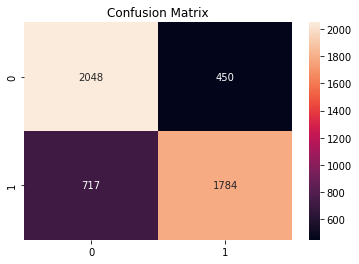

In [42]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(y_test, y_pred), annot=True, fmt='g').set_title("Confusion Matrix")


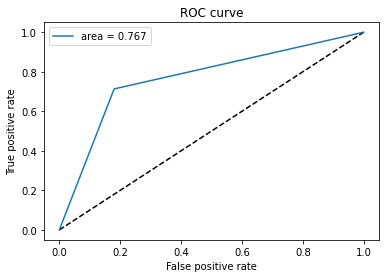

In [43]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [44]:
from sklearn import metrics
#Print classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      2498
           1       0.80      0.71      0.75      2501

    accuracy                           0.77      4999
   macro avg       0.77      0.77      0.77      4999
weighted avg       0.77      0.77      0.77      4999



sensibility 
Specificity 
Accurancy 

In [45]:
conf_matrix = tf.math.confusion_matrix(y_test, y_pred)

In [46]:
# Creating a function to report confusion metrics

# save confusion matrix and slice into four pieces
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

True Positives: tf.Tensor(1784, shape=(), dtype=int32)
True Negatives: tf.Tensor(2048, shape=(), dtype=int32)
False Positives: tf.Tensor(450, shape=(), dtype=int32)
False Negatives: tf.Tensor(717, shape=(), dtype=int32)


In [47]:
# calculate accuracy
conf_accuracy = ((TP+TN) / (TP + TN + FP + FN))

In [48]:
# calculate accuracy
conf_accuracy = (float(TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
conf_sensitivity = (float(TP) / float(TP + FN))
    # calculate the specificity
conf_specificity = (float(TN) / float(TN + FP))
    
    # calculate precision
conf_precision = (float(TN) / float(TN + FP))
    # calculate f_1 score
conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
print('*'*100)
print(f'Accuracy: {round(conf_accuracy,2)}') 
print(f'Mis-Classification: {round(conf_misclassification,2)}') 
print(f'Sensitivity: {round(conf_sensitivity,2)}') 
print(f'Specificity: {round(conf_specificity,2)}') 
print(f'Precision: {round(conf_precision,2)}')
print(f'f_1 Score: {round(conf_f1,2)}')

print('*'*100)

****************************************************************************************************
Accuracy: 0.77
Mis-Classification: 0.23
Sensitivity: 0.71
Specificity: 0.82
Precision: 0.82
f_1 Score: 0.76
****************************************************************************************************
